# ResNet-50 Implementation

## Introduction to ResNet (Residual Network)

__ResNet__ or __Residual Neural Network__ was proposed by researchers at Microsoft Research namely, _Kaiming He_, _Xiangyu Zhang_, _Shaoqing Ren_ and, _Jian Sun_; which also won [ImageNet](https://www.image-net.org/about.php) Challenge in 2015.

<center>
    <img src="./img/MicrosoftResearch.png" alt="Microsoft Research" width="500px"> <br>
</center>

## Importing Dependencies

In [1]:
# Import OpenCV which is a Computer Vision library and here we use it to deal with our image dataset
import cv2

# Import NumPy as our model trains on arrays which will be handled by NumPy
import numpy as np

# Import OS to interact with operating system
import os

# Import Math to use some mathematical computations
import math

# Import Shutil to move, copy and delete directories and sub-directories
import shutil

# Import glob module which finds all the pathnames matching a specified pattern according to the rules used by the Unix shell
import glob

# Import mayplotlib to visualize the metrics of our model
import matplotlib.pyplot as plt

# Import Keras
import keras

# Import Keras ImageDataGenerator which is used for getting the input of the original data and further, it makes the transformation of this data on a random basis and gives the output resultant containing only the data that is newly transformed.
from keras.preprocessing.image import ImageDataGenerator


from keras.models import Sequential, Model, load_model
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform
from keras.losses import categorical_crossentropy

In [2]:
!mkdir Animal-Classification-Dataset

In [3]:
!unzip Animal-Classification-Dataset.zip -d Animal-Classification-Dataset/

Archive:  Animal-Classification-Dataset.zip
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_1.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_10.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_100.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_1000.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_101.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_102.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_103.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_104.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_105.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_106.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_107.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_108.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_109.jpg  
  inflating: Animal-Classification-Dataset/Buffalo/Buffalo_11

In [4]:
DATASET_PATH = "Animal-Classification-Dataset"

In [5]:
number_of_images = {}

for dir in os.listdir(DATASET_PATH):
    number_of_images[dir] = len(os.listdir(os.path.join(DATASET_PATH, dir)))

In [6]:
number_of_images

{'Zebra': 1000, 'Elephant': 1000, 'Buffalo': 1000, 'Rhino': 1000}

In [7]:
def data_folder(folder_name, split_ratio):
    if not os.path.exists("./" + folder_name):
        os.mkdir("./" + folder_name)
    
    for dir in os.listdir(DATASET_PATH):
        if not os.path.exists("./" + folder_name + "/" + dir):
            os.makedirs("./" + folder_name + "/" + dir)

        for img in np.random.choice(a = os.listdir(os.path.join(DATASET_PATH, dir)), size = (math.floor(split_ratio * number_of_images[dir])), replace = False):
            O = os.path.join(DATASET_PATH, dir, img)
            D = os.path.join("./" + folder_name, dir)
            shutil.copy(O, D)
    
    else:
        print(f"{folder_name} Folder exist")

In [8]:
data_folder("Train", 0.7)

Train Folder exist


In [9]:
data_folder("Validate", 0.15)

Validate Folder exist


In [10]:
data_folder("Test", 0.15)

Test Folder exist


In [11]:
TRAIN_PATH = "./Train"

In [12]:
TEST_PATH = "./Test"

In [13]:
VALIDATE_PATH = "./Validate"

In [14]:
class_names_train = os.listdir(TRAIN_PATH)

In [15]:
class_names_test = os.listdir(TEST_PATH)

In [16]:
class_names_validate = os.listdir(VALIDATE_PATH)

In [17]:
print(class_names_train)

['Zebra', 'Elephant', 'Buffalo', 'Rhino']


In [18]:
print(class_names_test)

['Zebra', 'Elephant', 'Buffalo', 'Rhino']


In [19]:
print(class_names_validate)

['Zebra', 'Elephant', 'Buffalo', 'Rhino']


In [20]:
train_datagen = ImageDataGenerator(zoom_range = 0.15, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.15)
validate_datagen = ImageDataGenerator()

In [21]:
train_generator = train_datagen.flow_from_directory("./Train", target_size = (224, 224), batch_size = 32, shuffle=True, class_mode = 'categorical')
validate_generator = validate_datagen.flow_from_directory("./Validate", target_size = (224,224), batch_size = 32, shuffle = False, class_mode='categorical')

Found 2800 images belonging to 4 classes.
Found 600 images belonging to 4 classes.


In [22]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut]) # SKIP Connection
    X = Activation('relu')(X)

    return X

In [23]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [24]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [25]:
base_model = ResNet50(input_shape=(224, 224, 3))

2022-12-09 08:06:01.798217: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-09 08:06:02.207231: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 17969 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB MIG 3g.20gb, pci bus id: 0000:b7:00.0, compute capability: 8.0


In [26]:
print(base_model)

In [27]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel = Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='softmax', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [28]:
model = Model(inputs=base_model.input, outputs=headModel)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [30]:
model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [31]:
base_model.load_weights("./resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

In [32]:
for layer in base_model.layers:
    layer.trainable = False

In [33]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f319ffe3760> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f319bf818b0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f319bf81940> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f31ffc25340> False
<keras.layers.core.activation.Activation object at 0x7f2e6244f1f0> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f319bf81df0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f319ffef1c0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f319fff7be0> False
<keras.layers.core.activation.Activation object at 0x7f319fff7eb0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f319bfa1d90> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f319bf89760> False
<keras.layers.core.activation.Activation object at 0x7f319bfb5f70> False
<keras.layers.convolutional

In [36]:
es = EarlyStopping(monitor='val_accuracy', mode='auto', min_delta = 0.01, verbose=1, patience=20)

In [37]:
mc = ModelCheckpoint(filepath='./best_model.h5', monitor='val_accuracy', mode='auto', save_best_only=True)

In [38]:
H = model.fit_generator(train_generator, validation_data=validate_generator, epochs=100, steps_per_epoch=200, verbose=1, callbacks=[mc,es])

/tmp/ipykernel_1453385/2194974661.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(train_generator, validation_data=validate_generator, epochs=100, steps_per_epoch=200, verbose=1, callbacks=[mc,es])


Epoch 1/100


2022-12-09 08:07:32.768413: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-12-09 08:07:33.667042: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


InvalidArgumentError: Graph execution error:

Detected at node 'gradient_tape/model/fc3/MatMul/MatMul' defined at (most recent call last):
    File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/usr/local/lib/python3.8/dist-packages/traitlets/config/application.py", line 976, in launch_instance
      app.start()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/usr/local/lib/python3.8/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/ipkernel.py", line 383, in do_execute
      res = shell.run_cell(
    File "/usr/local/lib/python3.8/dist-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2881, in run_cell
      result = self._run_cell(
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 2936, in _run_cell
      return runner(coro)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3135, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3338, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py", line 3398, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_1453385/2194974661.py", line 1, in <cell line: 1>
      H = model.fit_generator(train_generator, validation_data=validate_generator, epochs=100, steps_per_epoch=200, verbose=1, callbacks=[mc,es])
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 2260, in fit_generator
      return self.fit(
    File "/usr/local/lib/python3.8/dist-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/usr/local/lib/python3.8/dist-packages/keras/engine/training.py", line 893, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 537, in minimize
      grads_and_vars = self._compute_gradients(
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 590, in _compute_gradients
      grads_and_vars = self._get_gradients(tape, loss, var_list, grad_loss)
    File "/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/optimizer_v2.py", line 471, in _get_gradients
      grads = tape.gradient(loss, var_list, grad_loss)
Node: 'gradient_tape/model/fc3/MatMul/MatMul'
Matrix size-incompatible: In[0]: [32,4], In[1]: [128,1]
	 [[{{node gradient_tape/model/fc3/MatMul/MatMul}}]] [Op:__inference_train_function_13394]

In [34]:
model.load_weights("./best_model.h5")

In [35]:
model.evaluate_generator(validate_generator)

/tmp/ipykernel_262574/3330584137.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(validate_generator)
2022-12-08 07:47:39.703015: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-12-08 07:47:40.563930: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


[0.05681881681084633, 0.9798084497451782]

In [36]:
model_json = model.to_json()
with open("./model.json","w") as json_file:
    json_file.write(model_json)

In [37]:
from keras.models import model_from_json

In [49]:
def predict_(image_path):
    #Load the Model from Json File
    json_file = open('./model.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    #Load the weights
    model_c.load_weights("./best_model.h5")
    #Compile the model
    opt = SGD(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    #load the image you want to classify
    image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224,224))
#     plt.imshow(image)
    #predict the image
    if image not None:
        preds = model_c.predict(np.expand_dims(image, axis=0))[0]
#     if preds == 0:
#         print("Predicted Label:Cat")
#     else:
#         print("Predicted Label: Dog")
    
    return preds

In [50]:
predict_("./Test/Dog/dog.1.jpg")

1/1 [==============================] - 1s 601ms/step


array([0.99881625], dtype=float32)

In [51]:
predict_("./Test/Cat/cat.1058.jpg")

1/1 [==============================] - 1s 605ms/step


array([7.4906006e-30], dtype=float32)

In [52]:
actual_labels = {}

for dir in os.listdir(TEST_PATH):
    actual_labels[dir] = len(os.listdir(os.path.join(TEST_PATH, dir)))

print(actual_labels)

{'Dog': 1936, 'Cat': 1947}


In [53]:
true_labels = {'Dog': 0, 'Cat': 0}
false_labels = {'Dog': 0, 'Cat': 0}

for dir in os.listdir(TEST_PATH):
    if dir == 'Dog':
        for img in os.listdir(os.path.join(TEST_PATH, dir)):
            if predict_(os.path.join(TEST_PATH, dir, img)) == 1:
                true_labels['Dog'] += 1
            elif predict_(os.path.join(TEST_PATH, dir, img)) == 0:
                false_labels['Dog'] += 1
    elif dir == 'Cat':
        for img in os.listdir(os.path.join(TEST_PATH, dir)):
            if predict_(os.path.join(TEST_PATH, dir, img)) == 0:
                true_labels['Cat'] += 1
            elif predict_(os.path.join(TEST_PATH, dir, img)) == 1:
                false_labels['Cat'] += 1

print(true_labels)
print(false_labels)

1/1 [==============================] - 1s 602ms/step


error: OpenCV(4.6.0) /io/opencv/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [54]:
true_labels

{'Dog': 275, 'Cat': 198}

In [55]:
false_labels

{'Dog': 1661, 'Cat': 1738}

In [65]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [66]:
labels = ['Dog', 'Cat']

print(labels)

['Dog', 'Cat']


In [67]:
# Confusion Matrix is a two dimensional matrix that visualizes the performance,
# and makes it easy to see confusion between classes,
# by providing a picture of interrelation

# Each row represents a number of actual, True class
# Each column represents a number of predicted class


# Computing Confusion Matrix to evaluate accuracy of classification
c_m = [[true_labels['Dog'], false_labels['Dog']], [false_labels['Cat'], true_labels['Cat']]]

# Showing Confusion Matrix in form of 2D Numpy array
print(c_m)

[[1661, 275], [198, 1738]]


In [68]:
c_m = np.array(c_m)

In [69]:
c_m

array([[1661,  275],
       [ 198, 1738]])

In [70]:
c_m.shape

(2, 2)

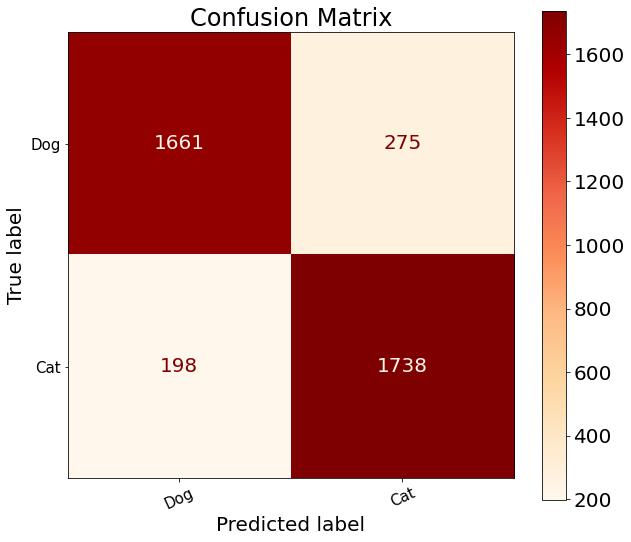

In [71]:
# Magic function that renders the figure in a jupyter notebook
# instead of displaying a figure object
%matplotlib inline


# Setting default size of the plot
# Setting default fontsize used in the plot
plt.rcParams['figure.figsize'] = (10.0, 9.0)
plt.rcParams['font.size'] = 20


# Implementing visualization of Confusion Matrix
display_c_m = ConfusionMatrixDisplay(c_m, display_labels=labels)


# Plotting Confusion Matrix
# Setting colour map to be used
display_c_m.plot(cmap='OrRd', xticks_rotation=25)
# Other possible options for colour map are:
# 'autumn_r', 'Blues', 'cool', 'Greens', 'Greys', 'PuRd', 'copper_r'


# Setting fontsize for xticks and yticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


# Giving name to the plot
plt.title('Confusion Matrix', fontsize=24)


# Saving plot
plt.savefig('confusion_matrix.png', transparent=True, dpi=500)


# Showing the plot
plt.show()